In [2]:
import pixeltable as pxt

videos = pxt.get_table("content")

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/xe/.pixeltable/pgdata


In [3]:
videos.list_views()

['frames']

In [4]:
frames = pxt.create_view("frames", videos, if_exists="ignore")

In [35]:
for idx, frame in enumerate(frames.select(frames.frame).sample(30).collect()["frame"]):
    frame.save(f"./var/whm/{idx}.jpeg")

In [25]:
from pixeltable.functions import openai

frames.add_computed_column(
    description=openai.vision(
        prompt="Describe what's happening in this frame",
        image=frames.frame,
        model="gpt-4.1-nano",
    ),
    if_exists="ignore",
)


Error: Exception in task: 
Traceback (most recent call last):
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/pixeltable/exec/expr_eval/schedulers.py", line 194, in _exec
    result = await pxt_fn.aexec(*request.args, **request_kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/pixeltable/func/callable_function.py", line 84, in aexec
    return await self.py_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/pixeltable/functions/openai.py", line 591, in vision
    rate_limits_info = env.Env.get().get_resource_pool_info(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/pixeltable/env.py", line 878, in get_resource_pool_info
    info = make_pool_info()
           ^^^^^^^^^^^^^^^^
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/pixeltable/functions/openai.py", line 592, in <lambda>
    resource_pool, lambda: OpenAIRateLimitsInfo(_vision_get_request_resources)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/pixeltable/functions/openai.py", line 193, in __init__
    import openai
ModuleNotFoundError: No module named 'openai'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/pixeltable/exec/expr_eval/expr_eval_node.py", line 396, in _done_cb
    t.result()
  File "/Users/xe/.local/share/uv/python/cpython-3.11.14-macos-aarch64-none/lib/python3.11/asyncio/futures.py", line 203, in result
    raise self._exception.with_traceback(self._exception_tb)
  File "/Users/xe/.local/share/uv/python/cpython-3.11.14-macos-aarch64-none/lib/python3.11/asyncio/tasks.py", line 277, in __step
    result = coro.send(None)
             ^^^^^^^^^^^^^^^
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/pixeltable/exec/expr_eval/schedulers.py", line 95, in _main_loop
    await self._exec(item.request, item.exec_ctx, item.num_retries, is_task=False)
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/pixeltable/exec/expr_eval/schedulers.py", line 213, in _exec
    assert self.pool_info is not None
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError


In [43]:
import pixeltable as pxt
from pixeltable.functions import openai

pxt.drop_table("wallpapers")
wallpapers = pxt.create_table(
    "wallpapers",
    schema={
        "text": pxt.String,
    },
    if_exists="ignore",
)

wallpapers.insert(
    [
        {"text": "A surrealist oil on canvas painting of a taco dancing in a datacentre"}
    ]
)

wallpapers.add_computed_column(
    gen_image=openai.image_generations(wallpapers.text, model='dall-e-2')
)

Created table 'wallpapers'.
Inserting rows into `wallpapers`: 1 rows [00:00, 873.45 rows/s]
Inserted 1 row with 0 errors.
Added 1 column value with 0 errors.


1 row updated, 1 value computed.

In [52]:
from __future__ import annotations

import base64
from pathlib import Path

from openai import OpenAI
from models.dd_solo import FrameDescription

client = OpenAI()

def describe_frame(jpeg_path: str | Path) -> FrameDescription:
    path = Path(jpeg_path)
    b64 = base64.b64encode(path.read_bytes()).decode("ascii")
    image_data_url = f"data:image/jpeg;base64,{b64}"

    prompt = (
        "Extract every field of FrameDescription from this Palace of the Dead frame. "
        "Use null for unknown values, keep messages chronological, and infer numbers."
    )

    response = client.responses.parse(
        model="gpt-5.1",
        input=[
            {
                "role": "user",
                "content": [
                    {"type": "input_text", "text": prompt},
                    {"type": "input_image", "image_url": image_data_url},
                ],
            }
        ],
        text_format=FrameDescription,
        max_output_tokens=800,
    )

    parsed = response.output[0].content[0].parsed
    if isinstance(parsed, FrameDescription):
        return parsed
    return FrameDescription(**parsed)

frame_description = describe_frame("var/whm/12.jpeg")

In [53]:
print(frame_description.model_dump_json(indent=2))

{
  "messages": [
    "You feel a surge of invigorating energy!",
    "Your body becomes shrouded in apotropaic shadows.",
    "The apotropaic shadows begin to flicker away.",
    "The apotropaic shadows fade away.",
    "The sustaining potion takes effect.",
    "The sustaining potion wears off.",
    "You obtain 1 sustaining potion.",
    "A piece of the Accursed Hoard is discovered on this floor!",
    "A piece of the Accursed Hoard has been discovered on the floor below!",
    "The magicite’s power can only be unleashed upon KO.",
    "You obtain 1 sustenance charm.",
    "A pomander of raising is activated.",
    "Its power will be negated upon KO.",
    "You obtain 1 sustaining potion.",
    "Only one sustenance charm may be carried at a time.",
    "You obtain 1 pomander of serenity.",
    "You obtain 1 pomander of flight.",
    "You obtain 1 pomander of petrification.",
    "You obtain 1 pomander of frailty.",
    "You obtain 1 pomander of witching.",
    "You obtain 1 sustaini

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from pixeltable.io import import_huggingface_dataset
from datasets import load_dataset

dataset = load_dataset("XeIaso/switch-screenshots")
screenshots = import_huggingface_dataset("screenshots", dataset)

/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating a Pixeltable instance at: /Users/xe/.pixeltable
Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/xe/.pixeltable/pgdata
Created table 'screenshots'.
Inserting rows into `screenshots`: 447 rows [00:06, 67.33 rows/s]
Inserting rows into `screenshots`: 447 rows [00:06, 66.22 rows/s]
Inserting rows into `screenshots`: 447 rows [00:06, 66.82 rows/s]
Inserting rows into `screenshots`: 447 rows [00:06, 65.47 rows/s]
Inserting rows into `screenshots`: 447 rows [00:07, 63.23 rows/s]
Inserting rows into `screenshots`: 447 rows [00:06, 69.62 rows/s]
Inserting rows into `screenshots`: 447 rows [00:06, 66.88 rows/s]
Inserting rows into `screenshots`: 185 rows [00:02, 79.50 rows/s]
Inserted 3314 rows with 0 errors.


In [2]:
import pixeltable as pxt

screenshots = pxt.get_table("screenshots")

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/xe/.pixeltable/pgdata


In [3]:
from pixeltable.functions.huggingface import clip

screenshots.add_embedding_index(
  "image",
  embedding=clip.using(model_id="openai/clip-vit-large-patch14"),
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step() created at /Users/xe/.local/share/uv/python/cpython-3.11.14-macos-aarch64-none/lib/python3.11/asyncio/tasks.py:130>
source_traceback: Object created at (most recent call last):
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/Users/xe/Code/tigrisdata-community/afflatus/.venv/lib/python3.11/site-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/Users/xe/.local/share/uv/python/cpython-3.11.14-macos-aarch64-none/lib/python3.11/asyncio/events.py", lin

similarity,image
0.237,
0.234,
0.232,
0.226,
0.226,

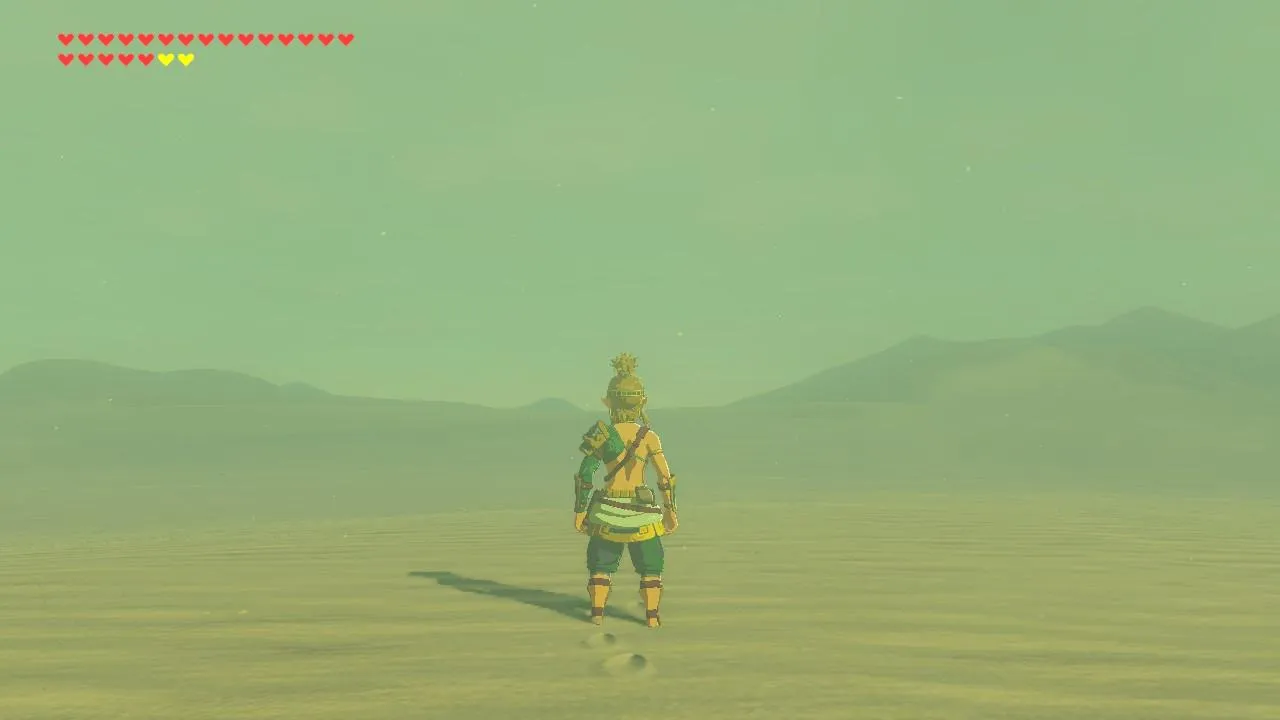
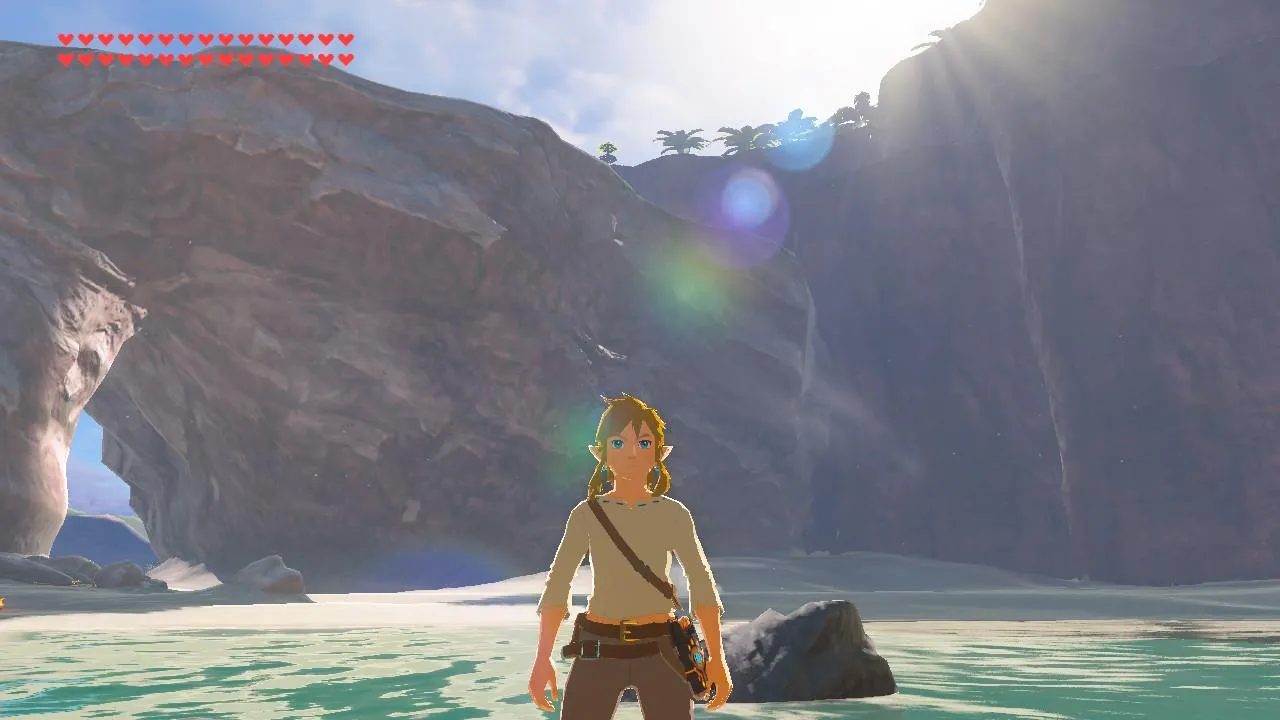
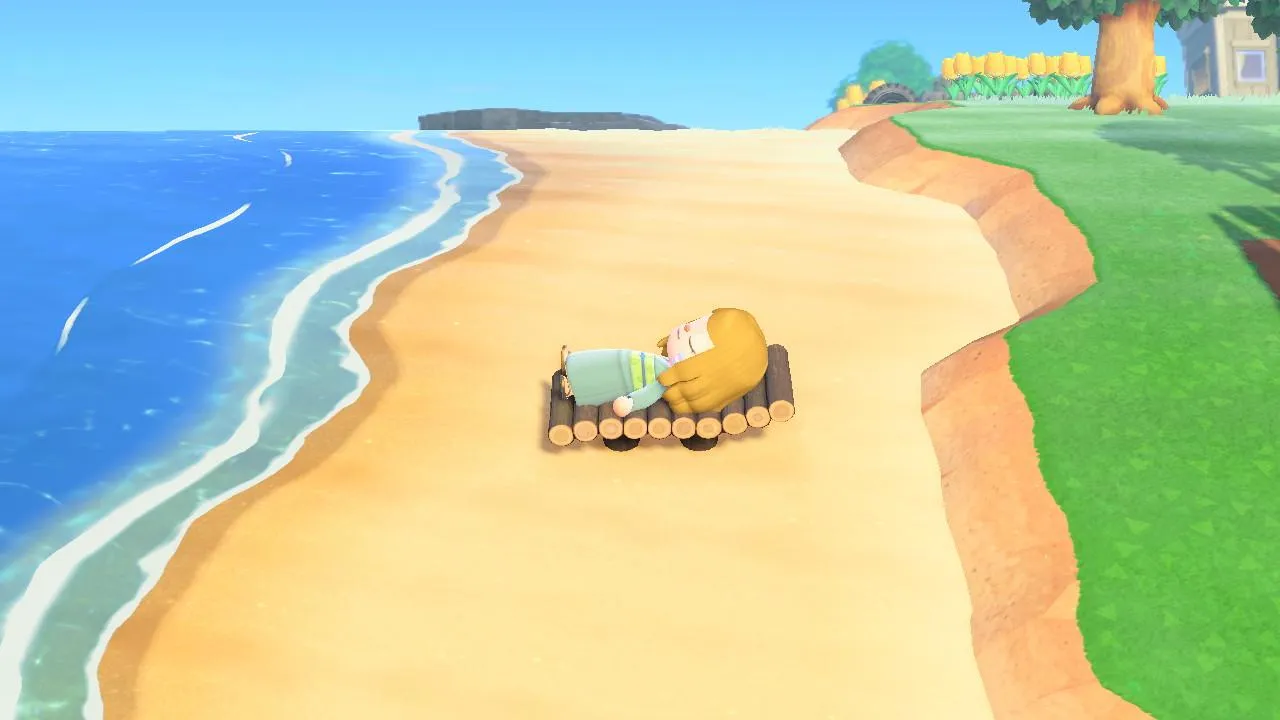
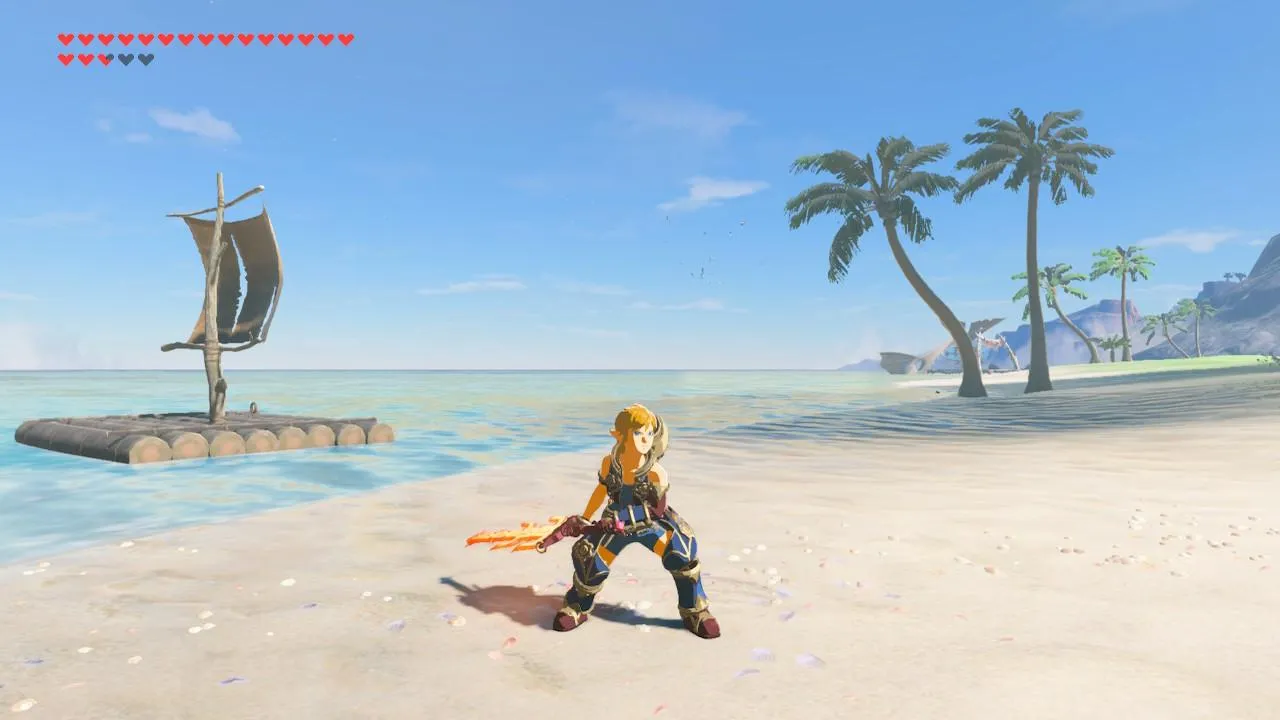
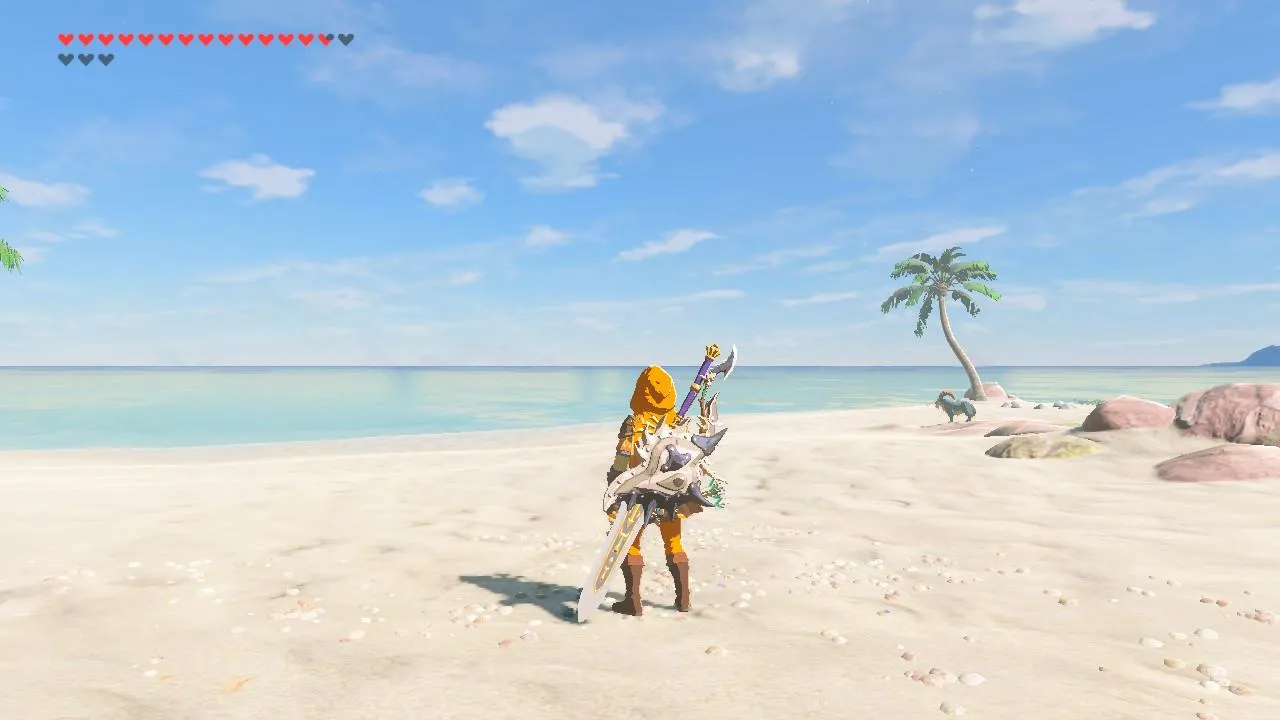

In [ ]:
query = "A man on the beach"
sim = screenshots.image.similarity(query)
results = (
    screenshots
    .order_by(sim, asc=False)
    .select(similarity=sim, image=screenshots.image)
    .limit(5)
)
results.collect()

In [6]:
from pixeltable.functions.huggingface import clip

screenshots.add_computed_column(
    image_embedding=clip(
        screenshots.image,
        model_id='openai/clip-vit-large-patch14'
    )
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Added 3314 column values with 0 errors.


3314 rows updated, 3314 values computed.

In [8]:
import pixeltable as pxt

pxt.ls()

,Name,Kind,Version,Base
,screenshots,table,8,


In [7]:
from transformers import CLIPModel, CLIPProcessor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')